# Operation Soar

### Goals
- Identify key drivers for airline passenger satisfaction by utilizing survey results
- Use those drivers to develop a ML model that accurately predicts whether a passenger is satisfied or dissatisfied
- Provide the business with key customer insights
- Provide at least one business recommendation that can help increase passenger satisfaction

#### Imports

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.stats as stats

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

import wrangle as w
import explore as e
import model as m

import warnings
warnings.filterwarnings('ignore')

## Data Dictionary

| Feature | Definition |
|:--------|:-----------|
|ID|ID associated with the passenger|
|customer type|Loyal or disloyal passenger|
|age|Age of the passenger who answered the survey|
|type_of_travel|Business or personal reason for travel|
|customer_class|Business, Eco Plus, or Eco seat selection|
|flight_distance|The distance each passenger travels to their destination|
|Survey Questions|(0:Not Applicable;1-5) 1 is the lowest rating for satisfaction and 5 is the highest|
|inflight_wifi_service|Satisfaction level of the inflight wifi service|
|departure_arrival_time_convenient|Satisfaction level of Departure/Arrival time convenient|
|ease_of_online_booking| Satisfaction level of online booking|
|gate_location|Satisfaction level of Gate location|
|food_and_drink|Satisfaction level of Food and drink|
|online_boarding|Satisfaction level of online boarding|
|seat_comfort|Satisfaction level of Seat comfort|
|inflight_entertainment|Satisfaction level of inflight entertainment|
|on_board_service|Satisfaction level of On-board service|
|leg_room_service|Satisfaction level of Leg room|
|baggage_handling|Satisfaction level of baggage handling|
|checkin_service|Satisfaction level of Check-in service|
|inflight_service|Satisfaction level of inflight service|
|cleanliness|Satisfaction level of Cleanliness|
|departure_delay_in_minutes|Minutes delayed for departure|
|arrival_delay_in_minutes|Minutes delayed for Arrival|
|satisfaction(Target Variable)|Airline satisfaction level(Satisfaction, neutral or dissatisfaction)|

# Wrangle

#### Acquire:
- Data was acquired from Kaggle
    - 1st data set consisted of 103,904 rows and 25 columns
    - 2nd data set consisted of 25,976 rows and 25 columns 
- Each row represents 1 customer survey
- Each column respresents a unique question or data point
#### Prepare:
- Combined the 2 data sets which resulted in 1 data frame consisting of 129,880 rows and 25 columns
- **Nulls:** Dropped 393 nulls
- Replaced special characters in column names with '_' and removed spaces
- Dropped 1 column named 'unnamed:_0'
- Renamed 'class' to 'customer_class' for exploration 
- Created dummy columns for columns with strings
- Data frame consisted of 129,487 row and 30 columns after nulls were dropped
- Split data into train, validate, test

In [2]:
# If running the notebook for the first time, this will combine and create a new csv. Otherwise it is read in the existing csv.
df = w.get_airline_data()

# Creating dummy columns that will be used during the modeling stage. 
df = w.prep_airline(df)

# Splitting into train, validate, and test BEFORE the exploration phase! Allons-y ('let's go')
train, validate, test = w.split_function(df, 'satisfaction')

Found CSV!
   og_df:  (129487, 30)
   Train:  (77691, 30)
Validate:  (25898, 30)
    Test:  (25898, 30)


# Exploration Phase

**Target Variable is ***satisfaction*****

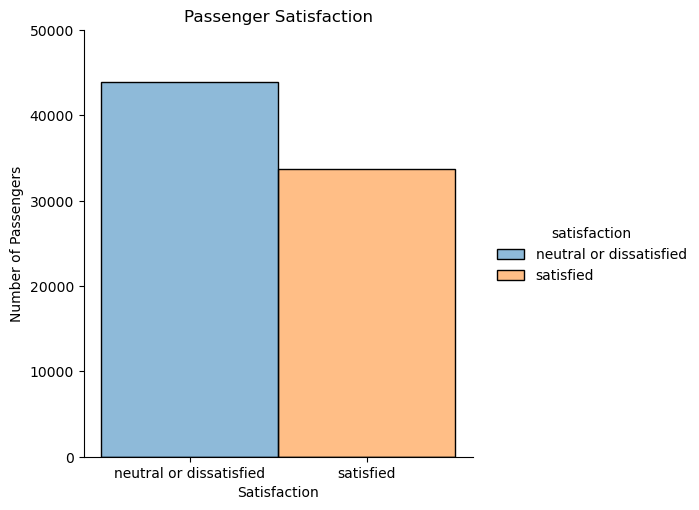

In [11]:
# Plotting the target variable to see distribution
sns.displot(data=train, x='satisfaction', hue='satisfaction')
plt.title('Passenger Satisfaction')
plt.xlabel('Satisfaction')
plt.ylabel('Number of Passengers')
plt.ylim(0,50_000)
plt.show()

## Does flight duration impact passenger satisfaction?
- My initial thoughts are, flights with longer durations result in less passenger satisfaction.

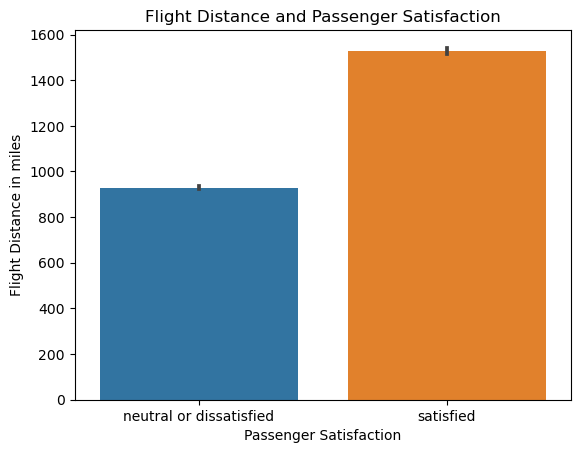

In [12]:
# Plotting customer satisfaction compared to flight distance
sns.barplot(data=train, x='satisfaction', y='flight_distance')
plt.title('Flight Distance and Passenger Satisfaction')
plt.xlabel('Passenger Satisfaction')
plt.ylabel('Flight Distance in miles')
plt.show()

$H_0$: Mean flight distance of satisfied passengers <= Mean flight distance of all passengers  
$H_a$: Mean flight distance of satisfied passengers > Mean flight distance of all passengers

In [5]:
# Utilizing function from explore.py to stats test my hypothesis
e.get_distance_satisfaction_ttest(train)

t = 55.43
p = 0.0
We reject the hypothesis


#### Takeaway:
- The mean flight distance for satisfied passengers is higher than the mean flight distance of all passengers
- Stats test showed that this is statistically significant
- Flight distance is a key driver for passenger satisfaction
- I did not expect this outcome. I initially hypothesized that longer duration flights would cause passengers to be less comfortable resulting in less passenger satisfaction.

## Does gender impact passenger satisfaction?

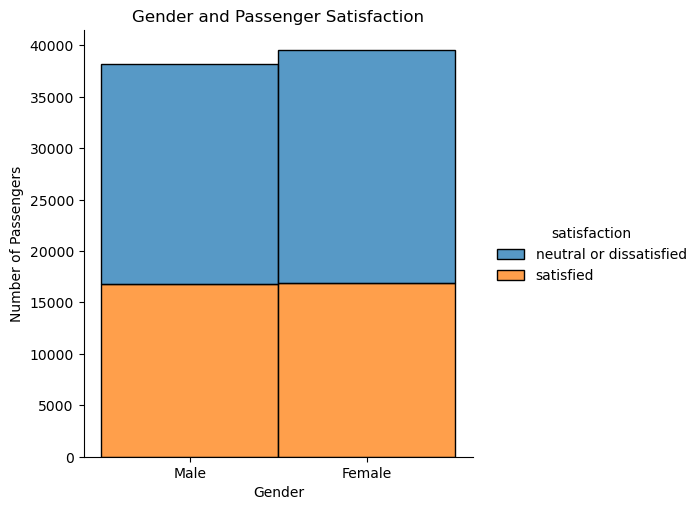

In [13]:
# Plotting gender compared to passenger satisfaction
sns.displot(data=train, x='gender', hue='satisfaction', multiple='stack')
plt.title('Gender and Passenger Satisfaction')
plt.xlabel('Gender')
plt.ylabel('Number of Passengers')
plt.show()

$H_0$: There is **no** association between passenger satisfaction and gender  
$H_a$: There is association between passenger satisfaction and gender

In [7]:
# Utilizing function from explore.py to stats test my hypothesis
e.get_chi2_results(train,'satisfaction', 'gender')

chi^2 = 14.4069
p.    = 0.0001
We reject the null hypothesis


gender,Female,Male
satisfaction,,
neutral or dissatisfied,22615,21320
satisfied,16911,16845


#### Takeaway:
- Although visually, gender doesn't appear to be significant; statistical significance shows that females are more dissatisfied than males.

## Does customer type (loyal vs disloyal) impact type of travel (business vs personal)?

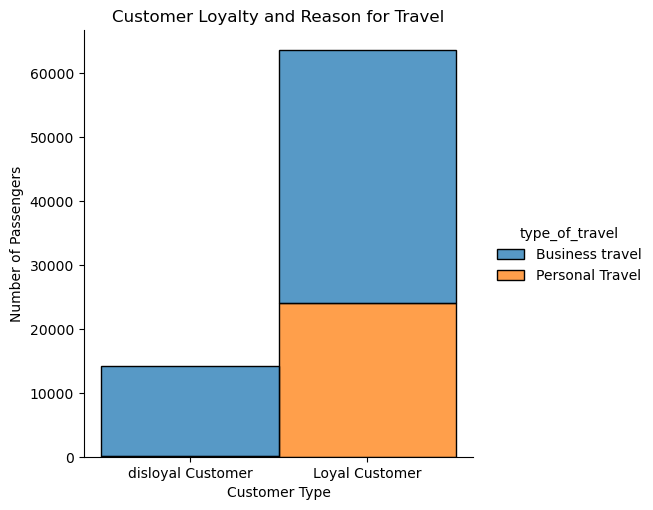

In [14]:
# Plotting customer type and type of travel to see distributions
sns.displot(data=train, x='customer_type', hue='type_of_travel', multiple='stack')
plt.title('Customer Loyalty and Reason for Travel')
plt.xlabel('Customer Type')
plt.ylabel('Number of Passengers')
plt.show()

$H_0$: There is **no** association between type of travel(personal vs business) and customer type(loyal vs disloyal)  
$H_a$: There is association between type of travel(personal vs business) and customer type(loyal vs disloyal)

In [9]:
# Utilizing function from explore.py to stats test my hypothesis
e.get_chi2_results(train, 'type_of_travel', 'customer_type')

chi^2 = 7389.8030
p.    = 0.0000
We reject the null hypothesis


customer_type,Loyal Customer,disloyal Customer
type_of_travel,,
Business travel,39491,14023
Personal Travel,24057,120


#### Takeaways:
- Disloyal customers overwhelmingly travel for business purposes.
- Loyal customers primarily travel for business purposes but make up the bulk of personal travelers (99.5%).
    - **Will utilize this metric in the next question**


## Does type of travel impact passenger satisfaction?

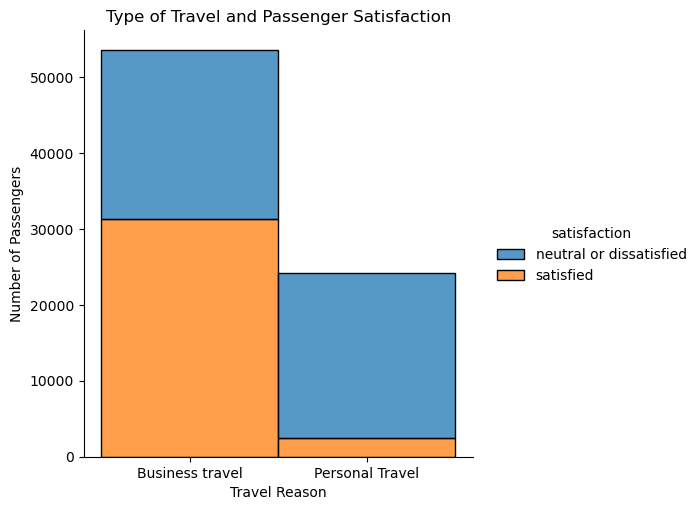

In [15]:
# Plotting type of travel and satisfaction to see distribution
sns.displot(data=train, x='type_of_travel', hue='satisfaction', multiple='stack')
plt.title('Type of Travel and Passenger Satisfaction')
plt.xlabel('Travel Reason')
plt.ylabel('Number of Passengers')
plt.show()

$H_0$: There is **no** association between type of travel(personal vs business) and passenger satisfaction  
$H_a$: There is association between type of travel(personal vs business) and passenger satisfaction

In [11]:
# Utilizing function from explore.py to stats test my hypothesis
e.get_chi2_results(train, 'satisfaction', 'type_of_travel')

chi^2 = 15696.3434
p.    = 0.0000
We reject the null hypothesis


type_of_travel,Business travel,Personal Travel
satisfaction,,
neutral or dissatisfied,22248,21687
satisfied,31266,2490


#### Takeaways:
- As stated in the previous question, 99.5% of personal travelers are loyal passengers
- **90%** of Loyal customers who are traveling for personal purposes are dissatisfied. 24,177 travelers in this category.

## Does customer loyalty impact satisfaction?

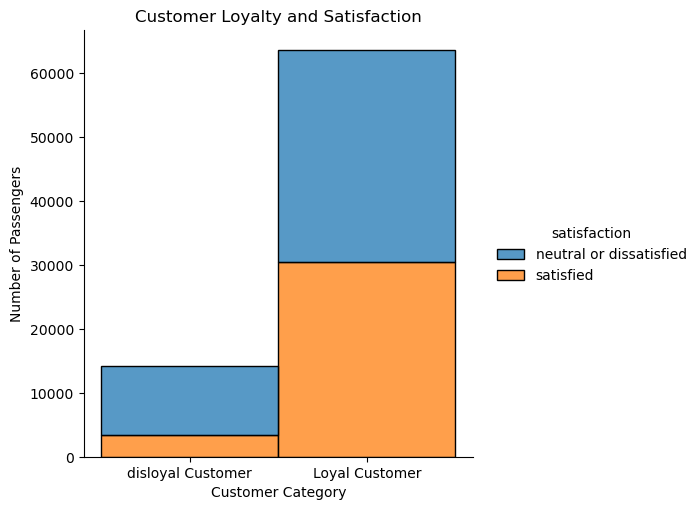

In [16]:
# Plotting customer type and satisfaction
sns.displot(data=train, x='customer_type', hue='satisfaction', multiple='stack')
plt.title('Customer Loyalty and Satisfaction')
plt.xlabel('Customer Category')
plt.ylabel('Number of Passengers')
plt.show()

$H_0$: There is **no** association between customer type(loyal vs disloyal) and passenger satisfaction  
$H_a$: There is association between customer type(loyal vs disloyal) and passenger satisfaction 

In [13]:
# Utilizing function from explore.py to stats test my hypothesis
e.get_chi2_results(train, 'satisfaction', 'customer_type')

chi^2 = 2747.3562
p.    = 0.0000
We reject the null hypothesis


customer_type,Loyal Customer,disloyal Customer
satisfaction,,
neutral or dissatisfied,33142,10793
satisfied,30406,3350


#### Takeaway:
- 48% of loyal customers are satisfied. 24% of disloyal customers are satisfied

## Exploration Summary:
- Passengers with shorter flights are dissatisfied at higher rates than customers who have longer flights
- Females are slightly more dissatisfied than males
- Loyal passengers make up 99.5% of the personal travel category
- 90% of loyal passengers who travel for personal reasons are dissatisfied
- Overall, 48% of loyal passengers are satisfied and 24% of disloyal passengers are satisfied

# Modeling

- 4 ML algorithms were used during this phase:
    - KNN, Decision Tree, Random Forest, and Logistical Regression
        - Multiple iterations were ran for each model and best model for each was selected to compare against the rest.
- **Evaluation metric: Accuracy**
- All features were used in the modeling phase with **exception** to:
    - id
        - Not needed for modeling.
    - gate location 
        - Gate locations are typically part of airline contracts with airports. I decided to not use that feature since airlines have minimal control or flexiblility to change gate locations.
    - leg room service
        - Since it isn't feasible to alter legroom for entire fleets, I decided to not use that feature in modeling.

In [14]:
# Initiating X_train/validate/test and y_train/validate/test for modeling utilizing function from model.py
X_train, X_validate, X_test, y_train, y_validate, y_test = m.Xy_train_val_test(train, validate, test, 'satisfaction_satisfied')

Baseline Accuracy: 56.55%


In [15]:
# Scaled data using MinMax scaler utilizing function from model.py
X_train_scaled, X_validate_scaled, X_test_scaled = m.scaled_df(X_train, X_validate, X_test)

### KNN

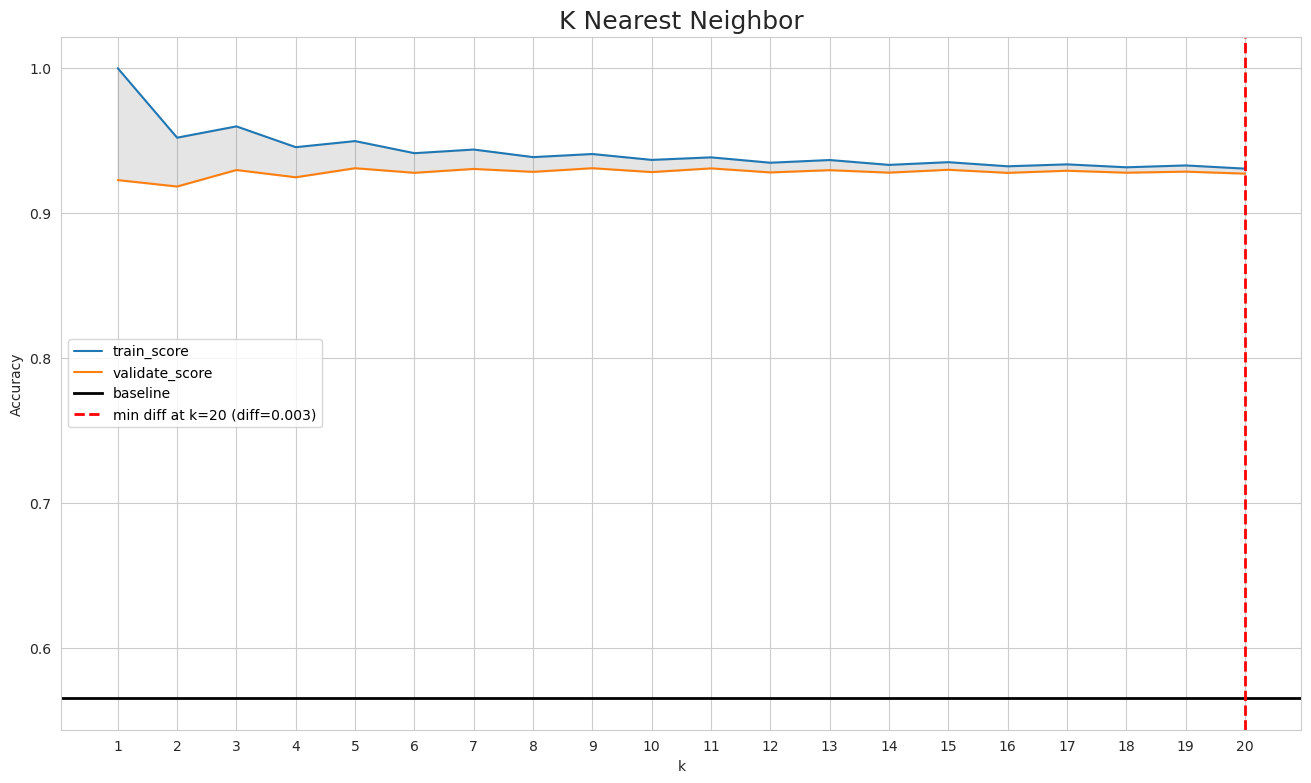

,k,train_score,validate_score,diff_score
10,11,0.938526,0.930921,0.007604


In [16]:
# Running function from model.py to find best KNN model, best KNN model selected
m.k_nearest2(X_train_scaled, y_train, X_validate_scaled, y_validate)[10:11]

#### KNN Model Takeaway:
- KNN with K=11 is the best performing KNN model
- Train accuracy = 93.85%
- Validate accuracy = 93.09%

### Decision Tree

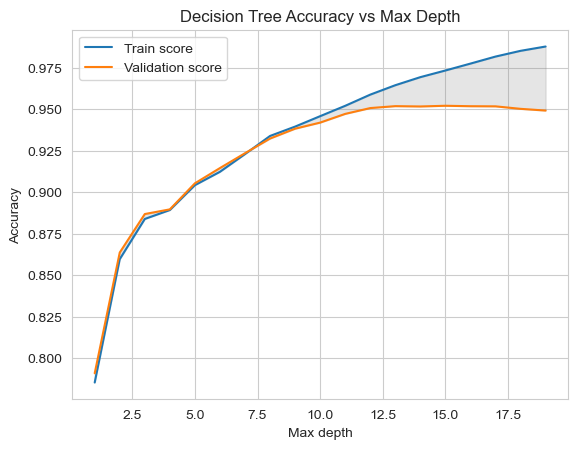

,max_depth,train_acc,val_acc,score_diff
11,12,0.958837,0.95073,0.008107


In [17]:
# Running function from model.py to find best Decision Tree model, best Decision Tree model selected
m.decision_tree(X_train_scaled, X_validate_scaled, y_train, y_validate)[11:12]

#### Decision Tree Model Takeaway:
- Decision Tree with max depth 12 is the best performing Decision Tree model
- Train accuracy = 95.88%
- Validate accuracy = 95.07%

### Random Forest

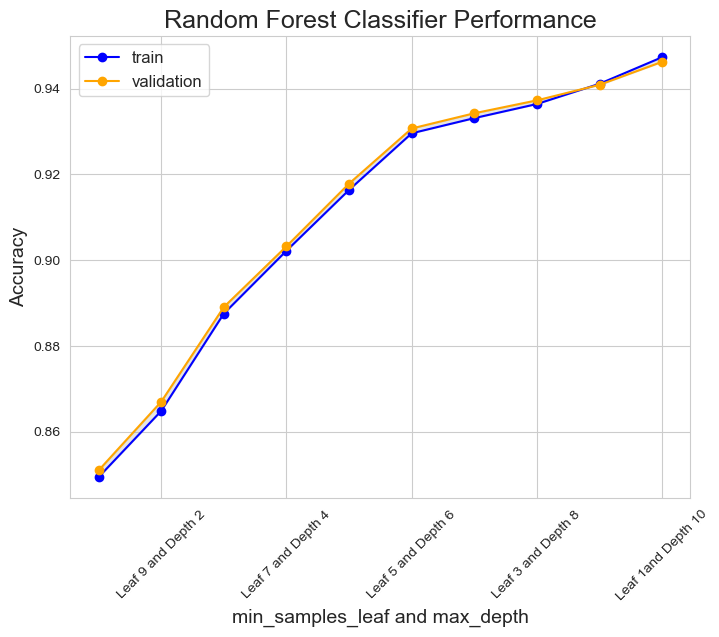

,min_samples_leaf,max_depth,train_score,validate_score,diff_score
0,1,10,0.947368,0.946289,0.001079


In [18]:
# Running function from model.py to find best Random Forest model, best Random Forest model selected
m.random_forest_scores(X_train_scaled, y_train, X_validate_scaled, y_validate)[0:1]

#### Random Forest Model Takeaway:
- Random Forest with min leaf samples = 1 and max depth = 10 is the best performing Random Forest model
- Train accuracy = 94.73%
- Validate accuracy = 94.62%

### Logistic Regression

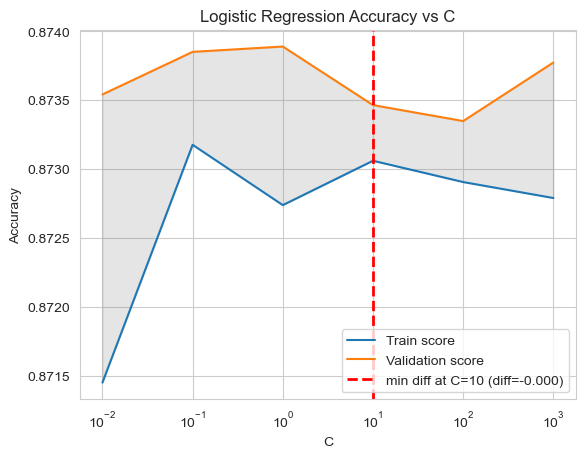

,C,train_score,validate_score,diff_score
1,0.1,0.873177,0.873851,-0.000674


In [19]:
# Running function from model.py to find best Logistic Regression model, best Logistic Regression model selected
m.plot_logistic_regression(X_train_scaled, X_validate_scaled, y_train, y_validate)[1:2]

#### Logistic Regression Model Takeaway:
- Logistic Regresssion with C = 0.1 is the best performing Logistic Regression model
- Train accuracy = 87.31%
- Validate accuracy = 87.38%

## Best Model

In [20]:
# Utilizing best model to run test data
m.best_model(X_train_scaled, X_test_scaled, y_train, y_test)

0.9457487064638196

Test accuracy = 94.57%

## Modeling Summary:
- Baseline accuracy was 56.55% and all models performed well above. 
- Logistic regression had the lowest performance at 87%.
- Best model was decision tree with a max depth of 12, which performed 38% above baseline.
- Used decision tree model on test and the result was 94.57% accuracy which was also 38% above baseline.
    - I would be confident using this model in production to predict passenger satisfaction for airline companies.

# Conclusions

## Exploration
- Identified 4 key drivers for passenger satisfaction
    - Flight distance
    - Gender
    - Type of travel (business vs personal)
    - Customer type (loyal vs disloyal)
## Modeling
- Best machine learning model performed 38% above baseline at 94.57%
## Recommendation
1. Prioritize loyal customers when developing a strategy to increase passenger satisfaction
    - Specifically loyal customers who travel for personal reasons
        - This segment accounts for nearly 19% of the total passenger population
        - This segment also accounts for nearly 50% of the toal of neutral or dissatisfied passengers
        - If we convert 50% of dissatisfied to satisfied passengers, the overall satisfaction of loyal customers would increase from 48% to 64%

## Next steps
- Explore how the business can convert disloyal business travelers to loyal business travelers with incentives
    - Then explore how to convert that segment to loyal personal travelers
- Consider altering the passenger survey to ask some "level of importance" questions
    - This could give the business more insights on what the customer wants and needs are
    - i.e. On a scale 1 - 5, how satisfied were you with inflight entertainment? By selecting important or not important, how do you rate the level of importance?

# Iterations
- Multiple iterations were done but due to the nature of the data (survey info), there was no room for feature engineering etc.